In [1]:
import os
from PIL import Image
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib.pyplot as plt

%set_env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [68]:
def import_images(directory, img_size=(224,224), ts_window=1, get_test_set=False, test_user=2):
    
    IMG_SHAPE = (1, img_size[0], img_size[1])
    
    # Create holding arrays by processing type for training set
    gaf_train = np.empty(shape=IMG_SHAPE, dtype='int')
    mtf_train = np.empty(shape=IMG_SHAPE, dtype='int')
    rp_train = np.empty(shape=IMG_SHAPE, dtype='int')
    
    gaf_train_label = np.empty(shape=(1,), dtype='int')
    mtf_train_label = np.empty(shape=(1,), dtype='int')
    rp_train_label = np.empty(shape=(1,), dtype='int')
    
    # Test set (only from test_user)
    gaf_test = np.empty(shape=IMG_SHAPE, dtype='int')
    mtf_test = np.empty(shape=IMG_SHAPE, dtype='int')
    rp_test = np.empty(shape=IMG_SHAPE, dtype='int')
    
    gaf_test_label = np.empty(shape=(1,), dtype='int')
    mtf_test_label = np.empty(shape=(1,), dtype='int')
    rp_test_label = np.empty(shape=(1,), dtype='int')
    
    cwd = directory
    
    for user in os.listdir(directory): # users 
        user_num = int(re.findall(r'\d+',user)[0]) #get user numbers
        dir1 = cwd
        for time_window in os.listdir(os.path.join(dir1, user)): #cwd + '/' + user): # time windows
            dir2 = os.path.join(dir1, user)
            for label in os.listdir(os.path.join(dir2, time_window)): #cwd + '/' + time_window):  # labels
                dir3 = os.path.join(dir2, time_window)
                for img_type in os.listdir(os.path.join(dir3, label)): #cwd + '/' + label): # processing types
                    dir4 = os.path.join(dir3, label) 
                    for img in os.listdir(os.path.join(dir4, img_type)): #cwd + '/' + img_type): # images
                            
                        # opening image as numpy array
                        img_arr = np.asarray(Image.open(os.path.join(dir4, img_type, img))) #cwd + '/' + img))
                            
                        if (user_num != test_user and get_test_set == False): # Training set
                            
                            # appending to respective arrays + adding dimension to image array so it fits
                            if (img_type == 'gaf'):
                                gaf_train = np.append(gaf_train, np.expand_dims(img_arr,axis=0), axis=0)
                                gaf_train_label = np.append(gaf_train_label, int(label))
                            elif (img_type == 'mtf'):
                                mtf_train = np.append(mtf_train, np.expand_dims(img_arr,axis=0), axis=0)
                                mtf_train_label = np.append(mtf_train_label, int(label))
                            elif (img_type == 'rp'):
                                rp_train = np.append(rp_train, np.expand_dims(img_arr,axis=0), axis=0)
                                rp_train_label = np.append(rp_train_label, int(label))
                            
                        elif (get_test_set): # LOSO test set
                                
                            # appending to respective arrays + adding dimension to image array so it fits
                            if (img_type == 'gaf'):
                                gaf_test = np.append(gaf_test, np.expand_dims(img_arr,axis=0), axis=0)
                                gaf_test_label = np.append(gaf_test_label, int(label))
                            elif (img_type == 'mtf'):
                                mtf_test = np.append(mtf_test, np.expand_dims(img_arr,axis=0), axis=0)
                                mtf_test_label = np.append(mtf_test_label, int(label))
                            elif (img_type == 'rp'):
                                rp_test = np.append(rp_test, np.expand_dims(img_arr,axis=0), axis=0)
                                rp_test_label = np.append(rp_test_label, int(label))
    
    if (get_test_set):
        return gaf_test, mtf_test, rp_test, gaf_test_label, mtf_test_label, rp_test_label
    else:
        return gaf_train, mtf_train, rp_train, gaf_train_label, mtf_train_label, rp_train_label

In [2]:
def import_data(directory, img_type, ts_window, test_user, img_size=(224,224)):
    
    IMG_SHAPE = (1, img_size[0], img_size[1])
    IMG_TYPE = img_type
    
    # Create holding arrays by processing type for training set
    x_train = np.empty(shape=IMG_SHAPE, dtype='int')   
    y_train = np.empty(shape=(1,), dtype='int')
    
    # Test set (only from test_user)
    x_test = np.empty(shape=IMG_SHAPE, dtype='int')    
    y_test = np.empty(shape=(1,), dtype='int')
    
    # selecting window size; 1 or 5 sec
    if ts_window == 1:
        TS_WINDOW = '1_seconds'
    else:
        TS_WINDOW = '5_seconds'
    
    for user in os.listdir(directory): # users directory
        user_num = int(re.findall(r'\d+',user)[0]) #get user number
        path = os.path.join(os.getcwd(), directory, user, TS_WINDOW)
        print('Processing ' + user + '...')
        
        for label in os.listdir(path): # label directory
            class_path = os.path.join(path, label, IMG_TYPE)

            for img in os.listdir(class_path): # image directory                      
                # opening image as numpy array
                img_arr = np.asarray(Image.open(os.path.join(class_path, img))) 
                
                if (user_num != test_user): 
                    # Training set
                    x_train = np.append(x_train, np.expand_dims(img_arr,axis=0), axis=0)
                    y_train = np.append(y_train, int(label))
                else:
                    # LOSO test set
                    x_test = np.append(x_test, np.expand_dims(img_arr,axis=0), axis=0)
                    y_test = np.append(y_test, int(label))
    
    # remove first elements in arrays as it's placeholder data from np.empty
    x_train = x_train[1:,:,:]
    y_train = y_train[1:]
    x_test = x_test[1:,:,:]
    y_test = y_test[1:]
    
    return x_train, y_train, x_test, y_test   

In [3]:
x_train, y_train, x_test, y_test = import_data('chev_zscore_withoutSMOTE_IRRlabels',
                                              'gaf', ts_window=1, test_user=2)

Processing user14...
Processing user9...
Processing user12...
Processing user11...
Processing user6...
Processing user4...
Processing user16...
Processing user3...
Processing user2...
Processing user5...
Processing user8...
Processing user13...


In [85]:
def remove_unused_dirs():
    import shutil
    f = [2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16]

    for i in f:
        path = os.path.join(os.getcwd(), 'chev_zscore_withoutSMOTE_IRRlabels', 'user' + str(i), '5_seconds')
        for j in [3,4]:
            shutil.rmtree(os.path.join(path, str(j)))
            print('removed ' + os.path.join(path, str(j)))

In [92]:
x_train.shape

(2539, 224, 224)

In [93]:
y_train.shape

(2539,)

In [96]:
x_test.shape

(224, 224, 224)

In [97]:
y_test.shape

(224,)

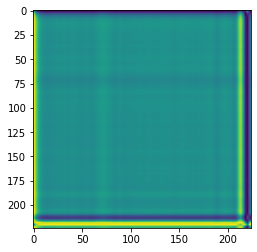

In [141]:
plt.imshow(x_test[0])

In [4]:
#preprocess data
x_train = x_train / 255
x_test = x_test / 255

In [3]:
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.utils import plot_model, to_categorical

# Good source: https://github.com/exekudos/se-resnet/blob/master/se_resnet.py
def sne_block(block_input, num_filters, ratio=8):
    
    pool1 = layers.GlobalAveragePooling2D()(block_input)
    flat = layers.Reshape((1, 1, num_filters))(pool1)
    dense1 = layers.Dense(num_filters//ratio, activation='relu')(flat)
    dense2 = layers.Dense(num_filters, activation='sigmoid')(dense1)
    scale = layers.multiply([block_input, dense2])
    
    return scale

In [4]:
def resnet_block(block_input, num_filters):
    
    if tf.keras.backend.int_shape(block_input)[3] != num_filters:
        block_input = layers.Conv2D(num_filters, kernel_size=(1,1))(block_input)
    
    conv1 = layers.Conv2D(num_filters, kernel_size=(3,3), padding='same')(block_input)
    norm1 = layers.BatchNormalization()(conv1)
    relu1 = layers.Activation('relu')(norm1)
    
    conv2 = layers.Conv2D(num_filters, kernel_size=(3,3), padding='same')(relu1)
    norm2 = layers.BatchNormalization()(conv2)
    
    sne = sne_block(norm2, num_filters=num_filters)
    
    sumation = layers.Add()([block_input, sne])
    relu2 = layers.Activation('relu')(sumation)
    
    return relu2

In [5]:
def sne_resnet14():
    
    ''' 
            SNE-ResNet 14 of ResNet 18
            Input: 224x224x1
            Output: 1x3
    '''
    
    inputs = layers.Input(shape=(224, 224, 1))
    conv1 = layers.Conv2D(64, kernel_size=(7,7), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    pool1 = layers.MaxPooling2D((2,2), strides=2)(conv1)
    
    block1 = resnet_block(pool1, 64)
    block2 = resnet_block(block1, 64)
    
    pool2 = layers.MaxPooling2D((2,2), strides=2)(block2)
    
    block3 = resnet_block(pool2, 128)
    block4 = resnet_block(block3, 128)
    
    pool3 = layers.MaxPooling2D((3,3), strides=2)(block4)
    
    block5 = resnet_block(pool3, 256)
    block6 = resnet_block(block5, 256)
    
    pool4 = layers.MaxPooling2D((3,3), strides=2)(block6)
    flat = layers.Flatten()(pool4)
    
    output = layers.Dense(3, activation='softmax')(flat)
    
    model = models.Model(inputs=inputs, outputs=output)
    
    # Compile model
    model.compile(loss=losses.categorical_crossentropy,
                 optimizer=optimizers.Adam(),
                 metrics=['accuracy'])
    
    return model

In [8]:
# adding channel dimension to fit with model input
x_test = np.expand_dims(x_test, axis=3)
x_train = np.expand_dims(x_train, axis=3)

In [9]:
x_train.shape

(2538, 224, 224, 1)

In [10]:
x_test.shape

(223, 224, 224, 1)

In [11]:
y_train.shape

(2538,)

In [12]:
# transform labels to categorical
y_tr = keras.utils.to_categorical(y_train)

In [13]:
y_te = keras.utils.to_categorical(y_test)

In [6]:
model = sne_resnet14()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
def preprocess_data1D(x_train, y_train, x_test, y_test, val_size=0.2):
    
    # normalize
    x_train = x_train / 255
    x_test = x_test / 255
    
    # adding channel dimension to fit with model input
    x_test = np.expand_dims(x_test, axis=3)
    x_train = np.expand_dims(x_train, axis=3)
    
    # transform labels to categorical using one-hot encoding
    y_train = keras.utils.to_categorical(y_train)
    y_test = keras.utils.to_categorical(y_test)
    
    # get validation set
    #from sklearn.model_selection import train_test_split

    #val_size = val_size # usually 20%
    #x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
    
    return x_train, y_train, x_test, y_test#, x_val, y_val 

In [7]:
def get_LOSO_processed_data(test_user, img_type, ts_window):
    
    # import data
    x_train, y_train, x_test, y_test = import_data('chev_zscore_withoutSMOTE_IRRlabels',
                                                   img_type=img_type,
                                                   ts_window=ts_window, 
                                                   test_user=test_user)
    
    # preprocess
    x_train, y_train, x_test, y_test = preprocess_data1D(x_train, y_train,x_test, y_test)
    return x_train, y_train, x_test, y_test#,x_val, y_val,

In [8]:
def run_LOSO_experiment(num_users, epochs, batch_size, img_type, ts_window, val_split=0.2):
    
    models = [None] * num_users
    user_nums = [2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16]
    train_hist = [None] * num_users
    val_hist = [None] * num_users
    
    # LOSO training 12 models
    for i in range(num_users):
        print('=== RUN #{}: using user #{} as test ==='.format(i+1,user_nums[i]))
        
        # create model
        models[i] = sne_resnet14()
        
        # get data
        x_train, y_train, x_test, y_test = get_LOSO_processed_data(test_user=user_nums[i],
                                                                   img_type=img_type,
                                                                   ts_window=ts_window)
        
        # train
        train_hist[i] = models[i].fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=val_split)
    
    return train_hist

In [9]:
# Run LOSO experiment
train_hist_gaf = run_LOSO_experiment(12, 15, 24, 'gaf', 1)

=== RUN #1: using user #2 as test ===
Processing user14...
Processing user9...
Processing user12...
Processing user11...
Processing user6...
Processing user4...
Processing user16...
Processing user3...
Processing user2...
Processing user5...
Processing user8...
Processing user13...
Epoch 1/15
85/85 [==============================] - 36s 429ms/step - loss: 2.6905 - accuracy: 0.5005 - val_loss: 0.9727 - val_accuracy: 0.5984
Epoch 2/15
85/85 [==============================] - 14s 163ms/step - loss: 1.0496 - accuracy: 0.5823 - val_loss: 1.0173 - val_accuracy: 0.5984
Epoch 3/15
85/85 [==============================] - 14s 164ms/step - loss: 0.9865 - accuracy: 0.5990 - val_loss: 1.0949 - val_accuracy: 0.5669
Epoch 4/15
85/85 [==============================] - 14s 164ms/step - loss: 0.9719 - accuracy: 0.6049 - val_loss: 1.0070 - val_accuracy: 0.5984
Epoch 5/15
85/85 [==============================] - 14s 164ms/step - loss: 0.9433 - accuracy: 0.6128 - val_loss: 0.9788 - val_accuracy: 0.5984
Ep

86/86 [==============================] - 14s 159ms/step - loss: 0.9432 - accuracy: 0.6079 - val_loss: 0.9785 - val_accuracy: 0.5926
Epoch 6/15
86/86 [==============================] - 14s 159ms/step - loss: 0.9396 - accuracy: 0.6108 - val_loss: 0.9729 - val_accuracy: 0.5926
Epoch 7/15
86/86 [==============================] - 14s 158ms/step - loss: 0.9379 - accuracy: 0.6089 - val_loss: 0.9739 - val_accuracy: 0.5926
Epoch 8/15
86/86 [==============================] - 14s 158ms/step - loss: 0.9266 - accuracy: 0.6108 - val_loss: 0.9989 - val_accuracy: 0.5926
Epoch 9/15
86/86 [==============================] - 14s 158ms/step - loss: 0.9537 - accuracy: 0.5996 - val_loss: 18.8155 - val_accuracy: 0.2047
Epoch 10/15
86/86 [==============================] - 14s 159ms/step - loss: 0.9316 - accuracy: 0.6113 - val_loss: 1.1099 - val_accuracy: 0.5945
Epoch 11/15
86/86 [==============================] - 14s 159ms/step - loss: 0.9231 - accuracy: 0.6118 - val_loss: 1.0690 - val_accuracy: 0.5945
Epoch 1

83/83 [==============================] - 13s 160ms/step - loss: 0.8870 - accuracy: 0.6284 - val_loss: 1.1911 - val_accuracy: 0.3239
Epoch 12/15
83/83 [==============================] - 13s 160ms/step - loss: 0.8531 - accuracy: 0.6334 - val_loss: 1.1406 - val_accuracy: 0.4769
Epoch 13/15
83/83 [==============================] - 13s 159ms/step - loss: 0.8624 - accuracy: 0.6234 - val_loss: 1.0297 - val_accuracy: 0.5976
Epoch 14/15
83/83 [==============================] - 13s 160ms/step - loss: 0.8144 - accuracy: 0.6511 - val_loss: 0.9778 - val_accuracy: 0.5915
Epoch 15/15
83/83 [==============================] - 13s 159ms/step - loss: 0.8200 - accuracy: 0.6556 - val_loss: 1.2707 - val_accuracy: 0.3199
=== RUN #8: using user #11 as test ===
Processing user14...
Processing user9...
Processing user12...
Processing user11...
Processing user6...
Processing user4...
Processing user16...
Processing user3...
Processing user2...
Processing user5...
Processing user8...
Processing user13...
Epoch 1/

Processing user3...
Processing user2...
Processing user5...
Processing user8...
Processing user13...
Epoch 1/15
86/86 [==============================] - 24s 275ms/step - loss: 2.9249 - accuracy: 0.5307 - val_loss: 0.9846 - val_accuracy: 0.5914
Epoch 2/15
86/86 [==============================] - 14s 159ms/step - loss: 1.0838 - accuracy: 0.5414 - val_loss: 1.2471 - val_accuracy: 0.5914
Epoch 3/15
86/86 [==============================] - 14s 162ms/step - loss: 1.0724 - accuracy: 0.5414 - val_loss: 1.2027 - val_accuracy: 0.5914
Epoch 4/15
86/86 [==============================] - 15s 169ms/step - loss: 0.9708 - accuracy: 0.5949 - val_loss: 1.0549 - val_accuracy: 0.5914
Epoch 5/15
86/86 [==============================] - 15s 172ms/step - loss: 0.9248 - accuracy: 0.6110 - val_loss: 1.1515 - val_accuracy: 0.5914
Epoch 6/15
86/86 [==============================] - 14s 166ms/step - loss: 0.9124 - accuracy: 0.6149 - val_loss: 0.9860 - val_accuracy: 0.5914
Epoch 7/15
86/86 [=======================

### Benchmarks

- Default model:
    - 1D-GAF (test user / training accuracy / validation accuracy):
        - Average validation accuracy: 0.4790
        - 2 - 0.6202 - 0.5630
        - 3 - 0.6529 - 0.3272 (~0.63)
        - 4 - 0.6283 - 0.2084 (~0.61)
        - 5 - 0.6196 - 0.5945
        - 8 - 0.5578 - 0.5359
        - 9 - 0.6556 - 0.5915
        - 11 - 0.6480 - 0.6100
        - 12 - 0.6252 - 0.5050 (~0.61)
        - 13 - 0.6334 - 0.57
        - 14 - 0.6422 - 0.4125
        - 15 - 0.5983 - 0.5435
    

In [45]:
def plot_accuracy_val(train_hist, epochs=15):
    
    '''
        Plot training vs. validation loss and accuracy
    '''
    
    user_nums = [2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16]
    
    for i in range(len(train_hist_gaf)):

        hist = train_hist_gaf[i].history

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))
        fig.suptitle('LOSO Model for Test User {}'.format(user_nums[i]))
        ax1.plot(range(epochs), hist['accuracy'], label='training')
        ax1.plot(range(epochs), hist['val_accuracy'], label='validation')
        ax1.set_title('Accuracy')
        ax1.legend()
        ax1.grid()
        
        ax2.plot(range(epochs), hist['loss'], label='training')
        ax2.plot(range(epochs), hist['val_loss'], label='validation')
        ax2.set_title('Loss')
        ax2.grid()
        ax2.legend()

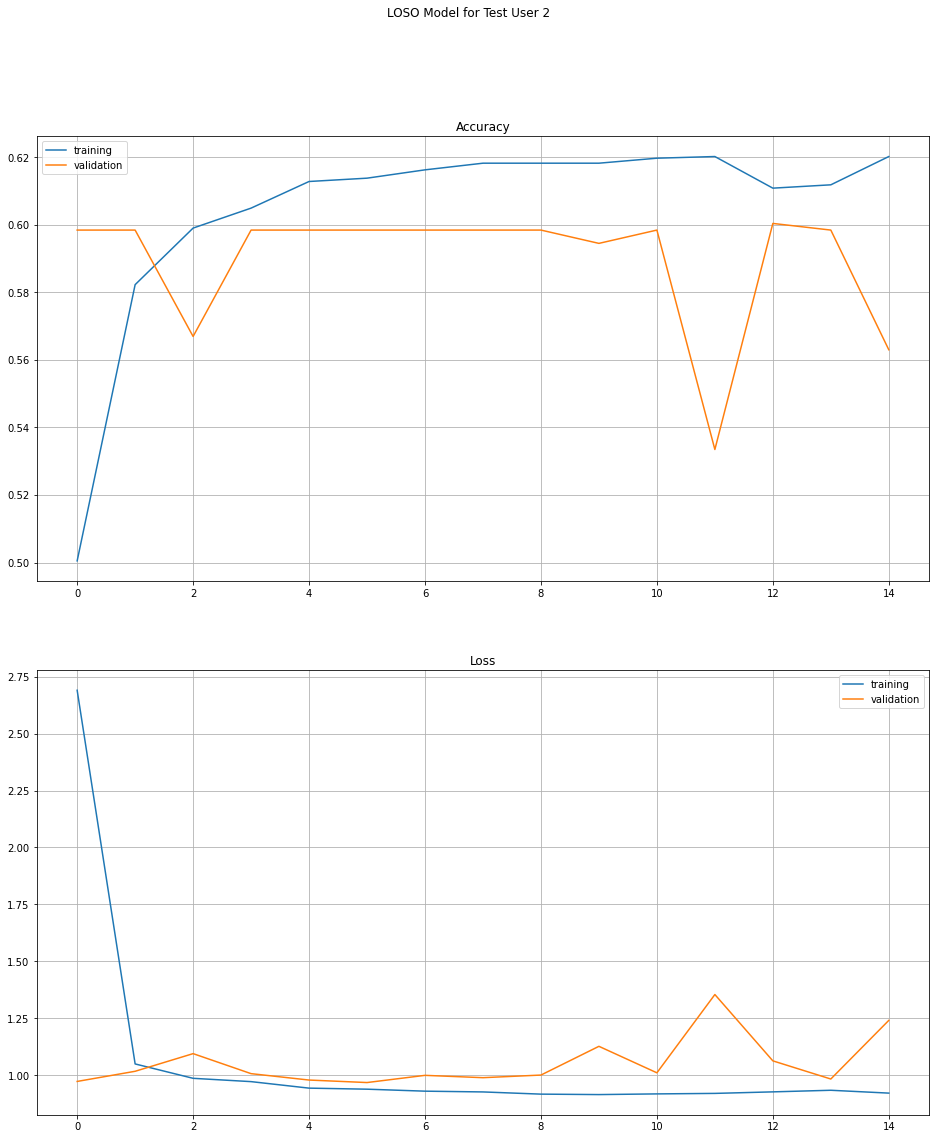

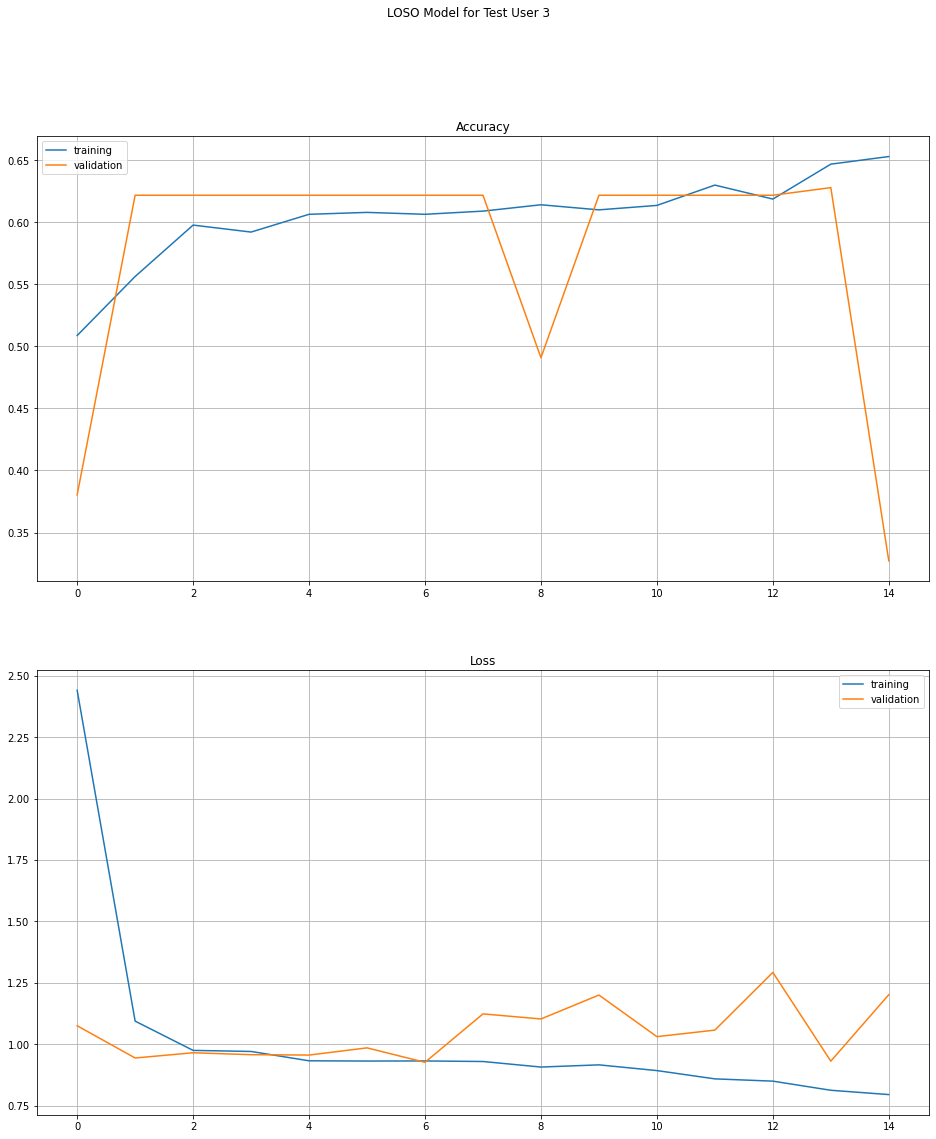

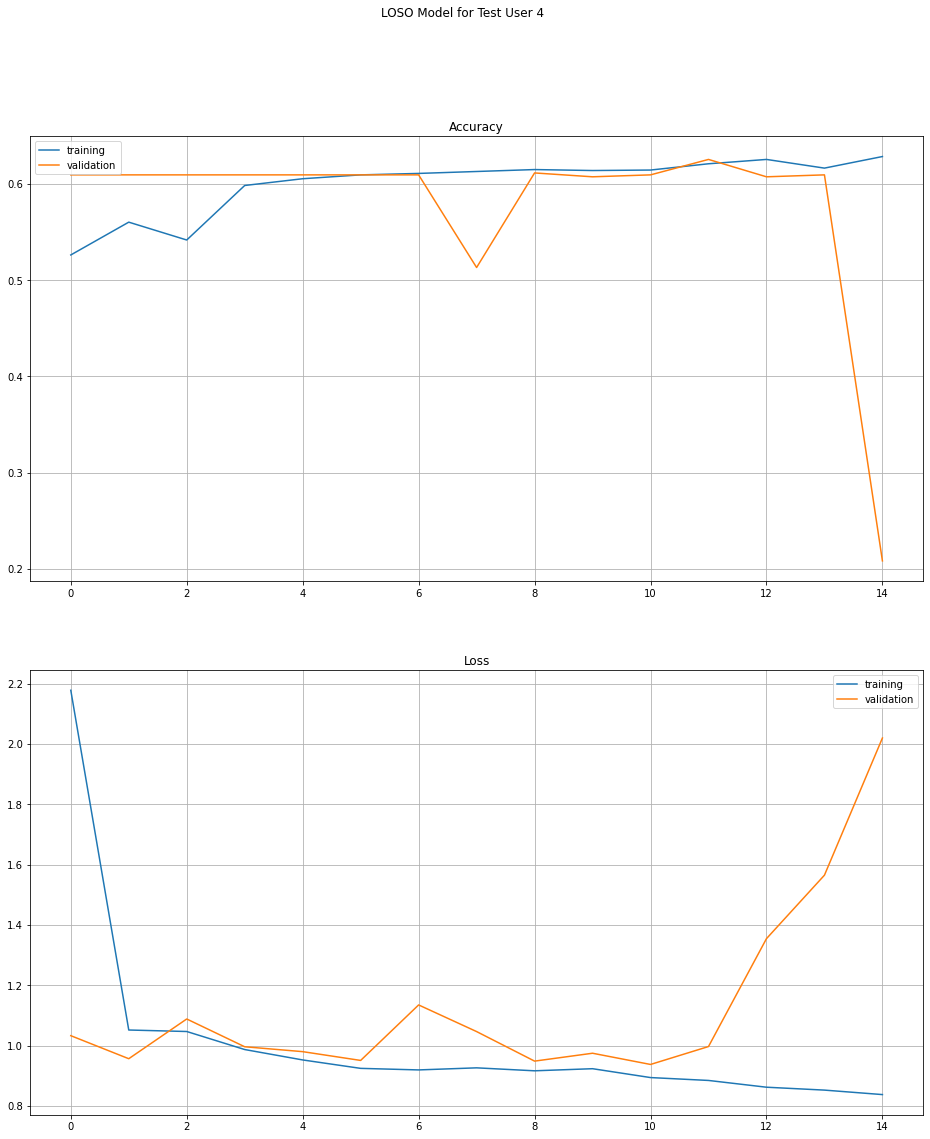

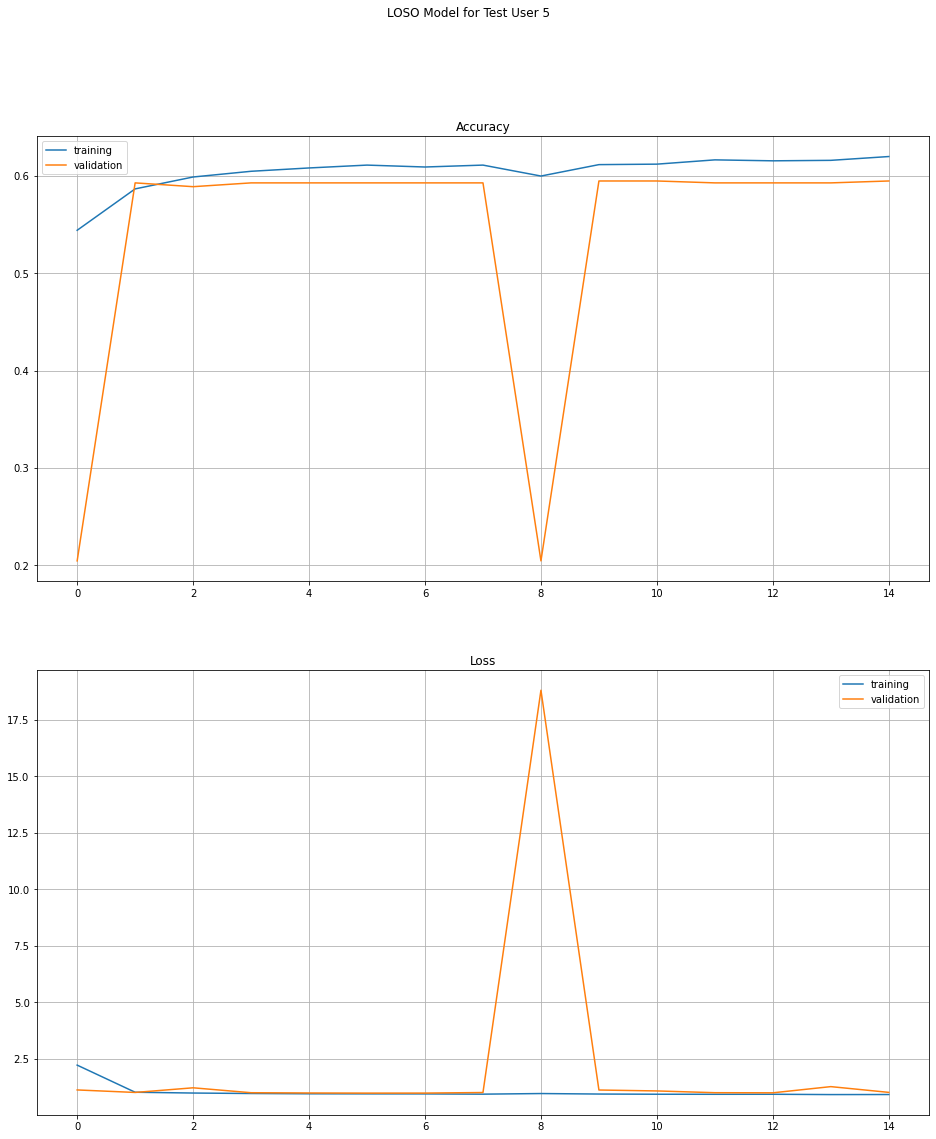

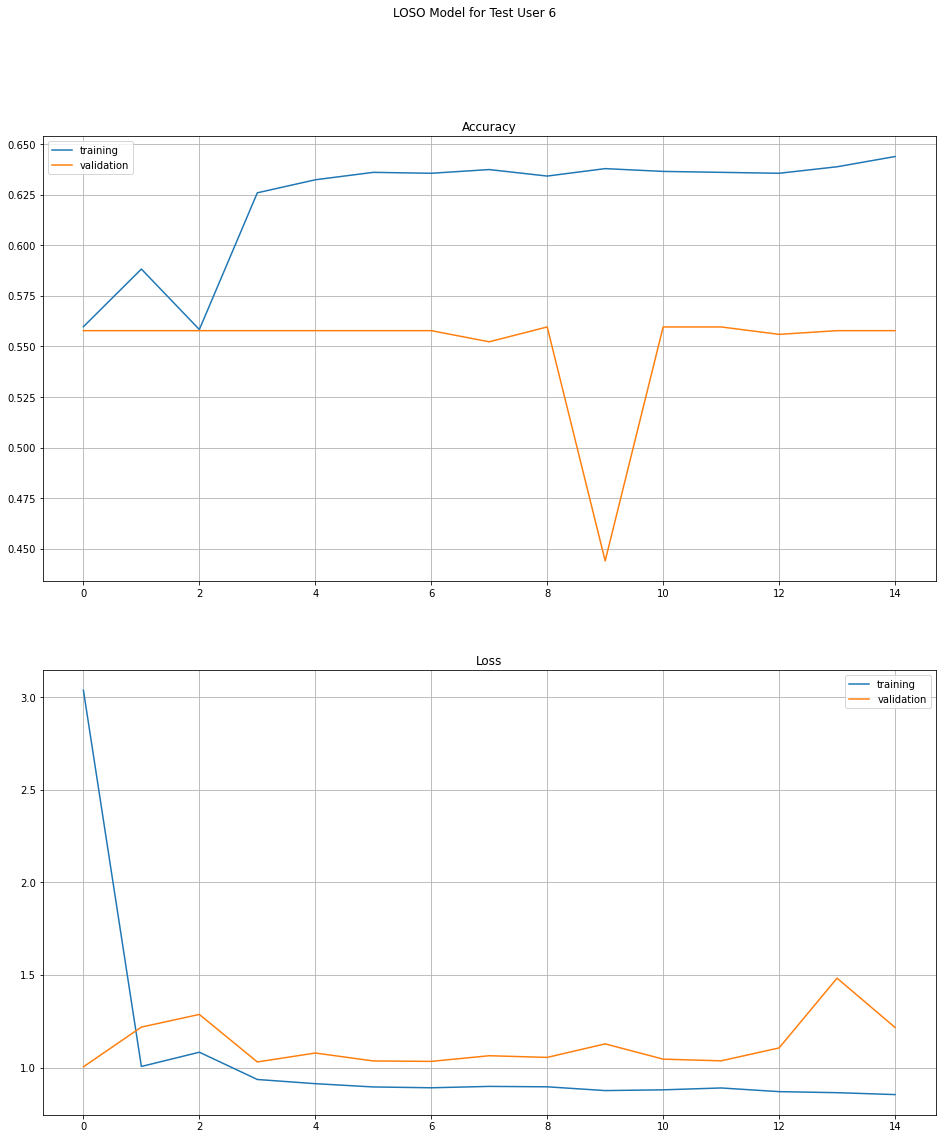

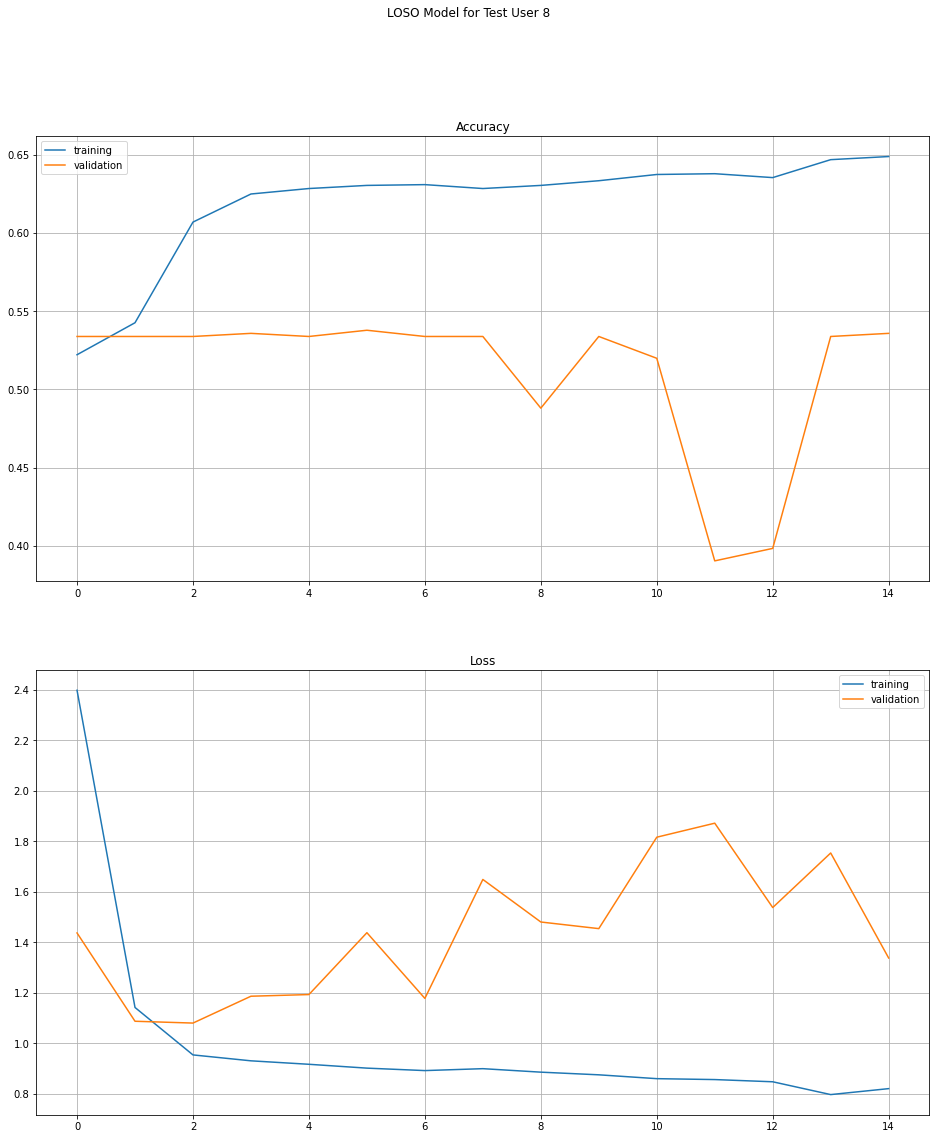

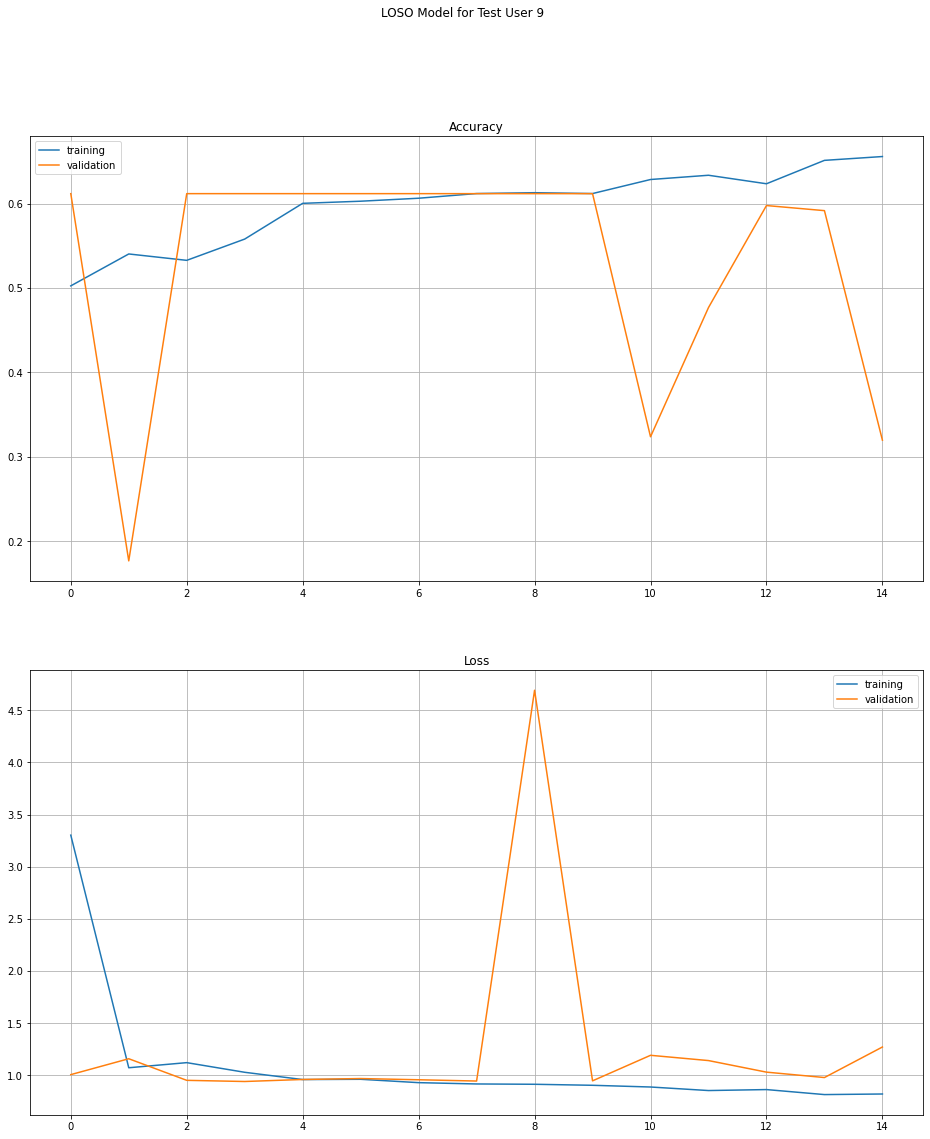

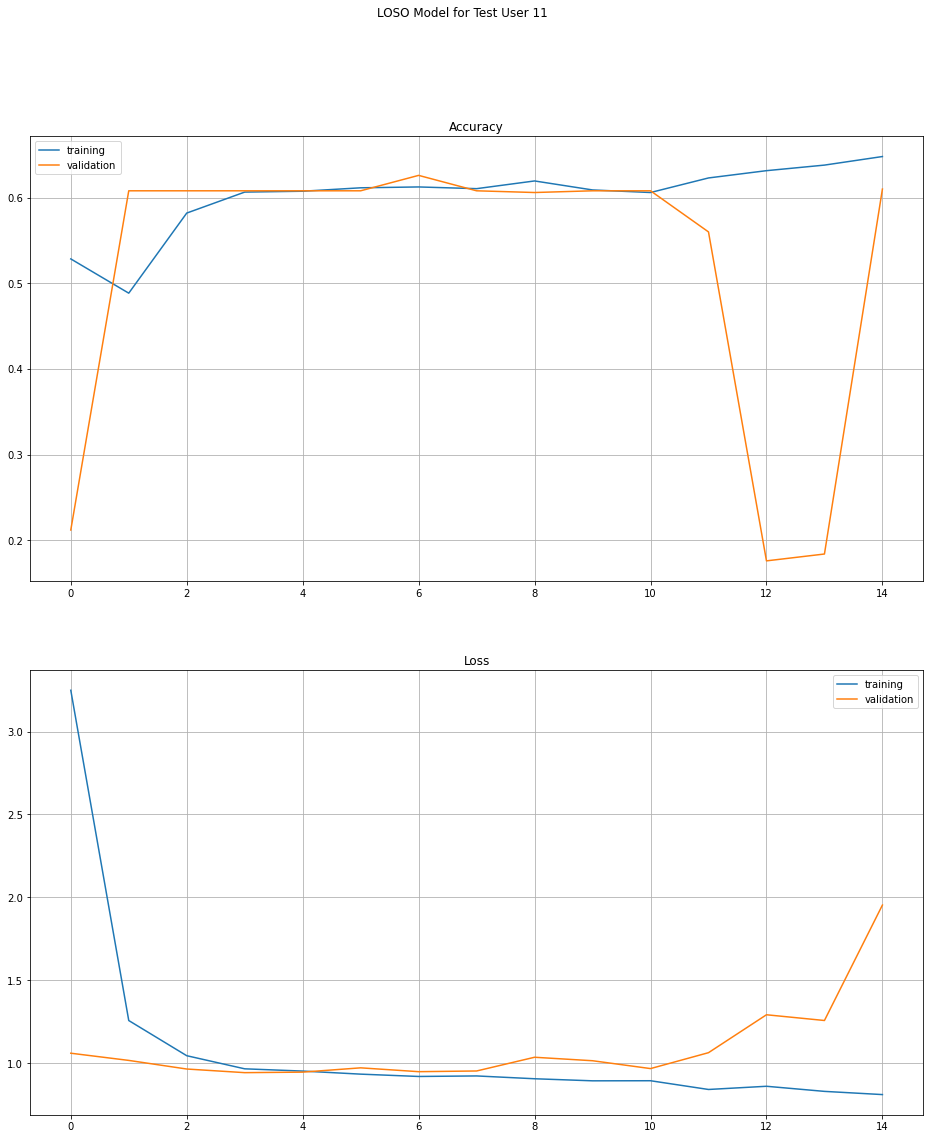

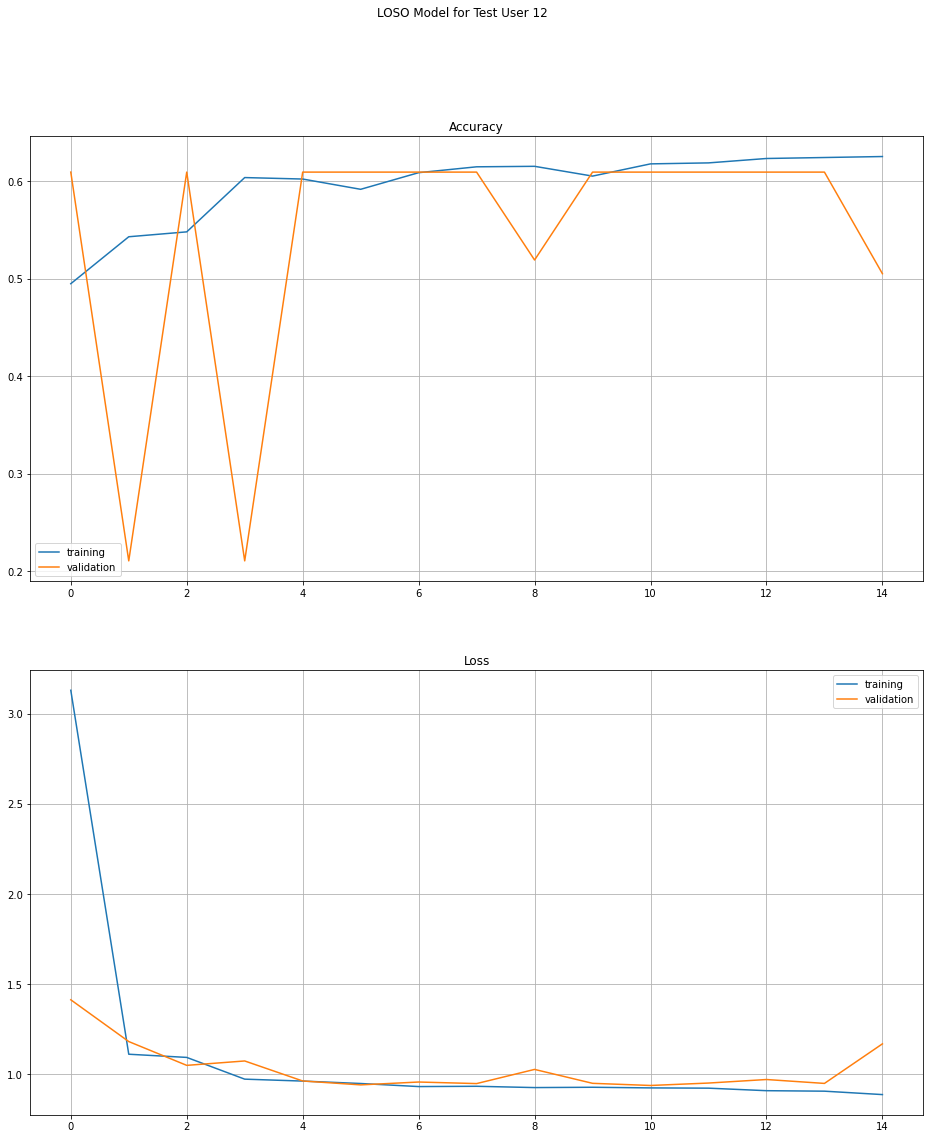

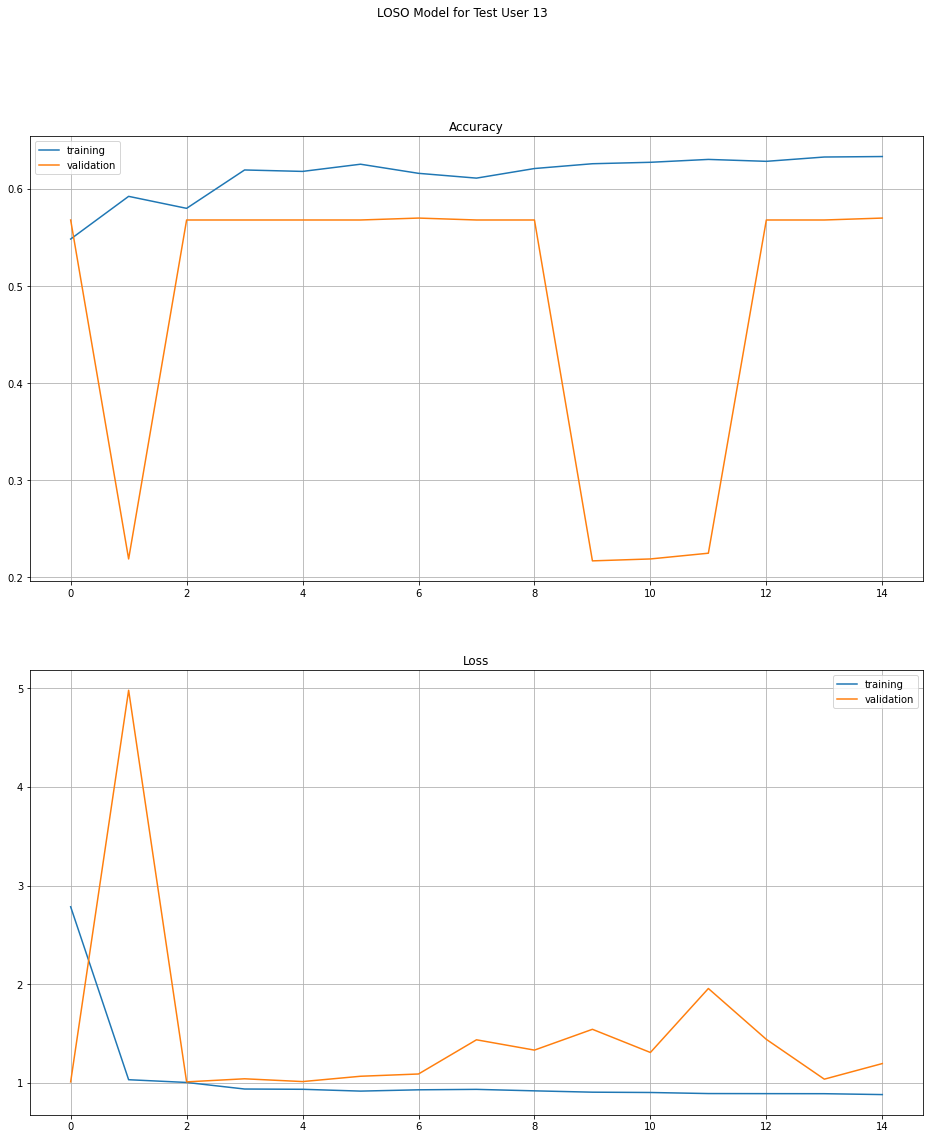

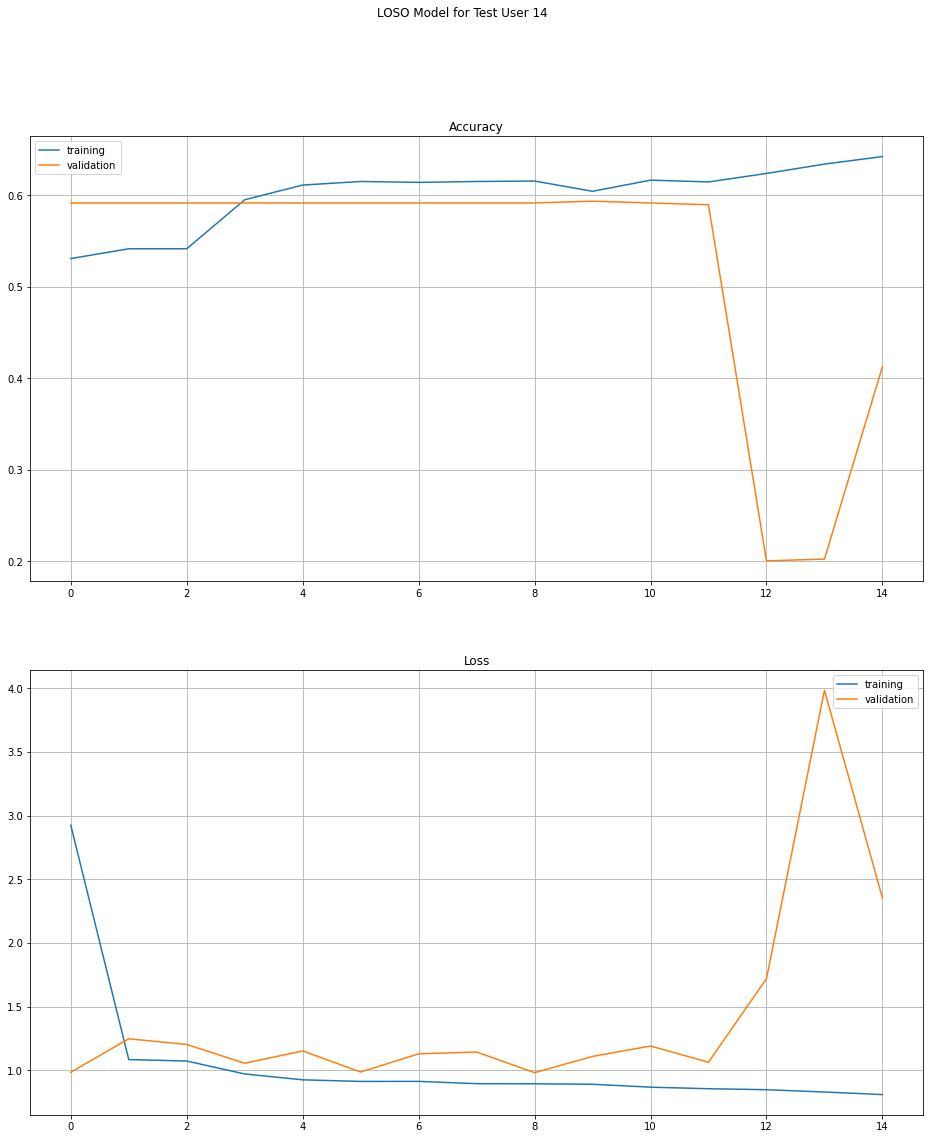

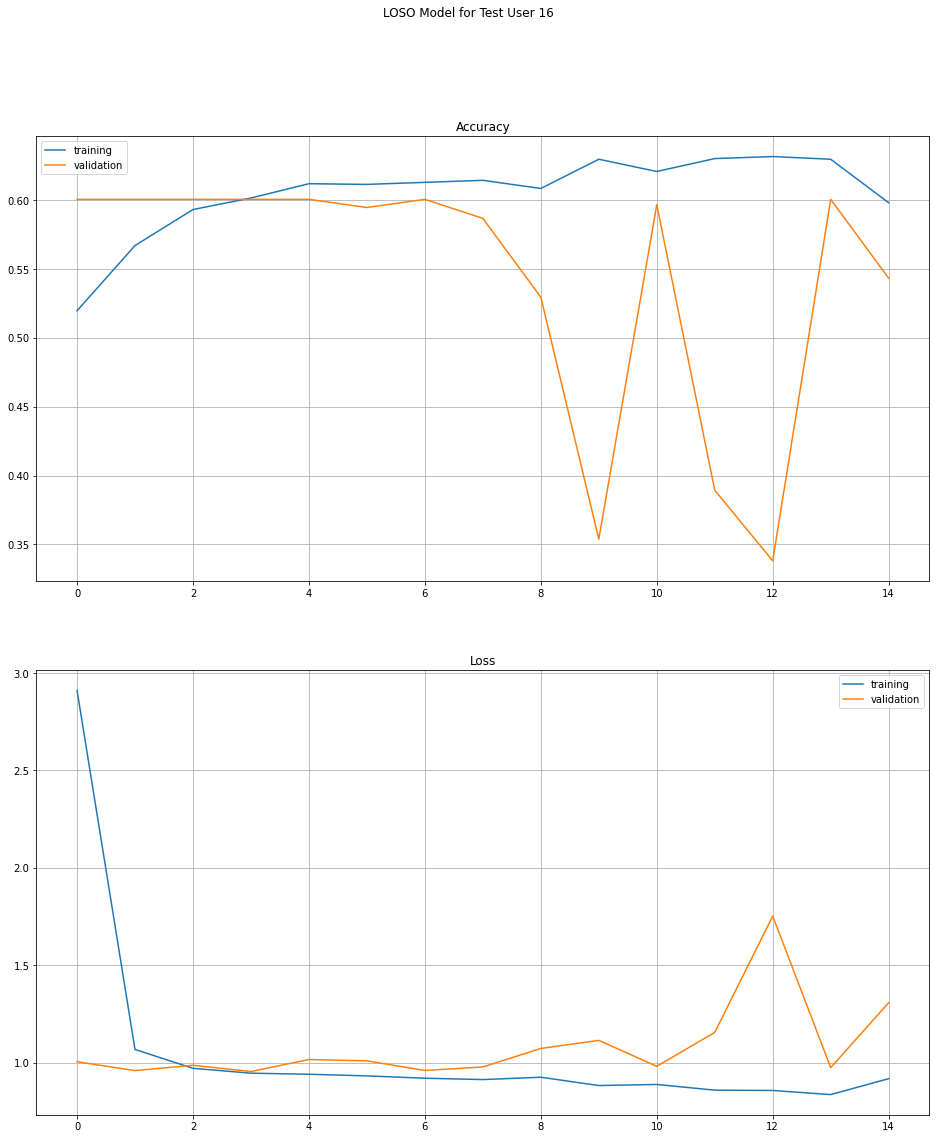

In [46]:
plot_accuracy_val(train_hist)

In [15]:


# Training
train_history = model.fit(x_train,
                         y_tr,
                         batch_size=24,
                         epochs=10,
                         verbose=1)

# Eval on validation set TODO MAKE VALIDATION
val_result = model.evaluate(x_test,
                           y_te,
                           verbose=1)

Epoch 1/10
106/106 [==============================] - 32s 297ms/step - loss: 2.8461 - accuracy: 0.5280
Epoch 2/10
106/106 [==============================] - 15s 146ms/step - loss: 1.0775 - accuracy: 0.5426
Epoch 3/10
106/106 [==============================] - 16s 155ms/step - loss: 1.0584 - accuracy: 0.5686
Epoch 4/10
106/106 [==============================] - 16s 155ms/step - loss: 1.0019 - accuracy: 0.5804
Epoch 5/10
106/106 [==============================] - 16s 155ms/step - loss: 0.9603 - accuracy: 0.6091
Epoch 6/10
106/106 [==============================] - 16s 155ms/step - loss: 0.9512 - accuracy: 0.6095
Epoch 7/10
106/106 [==============================] - 17s 156ms/step - loss: 0.9474 - accuracy: 0.6099
Epoch 8/10
106/106 [==============================] - 16s 156ms/step - loss: 0.9443 - accuracy: 0.6091
Epoch 9/10
106/106 [==============================] - 17s 156ms/step - loss: 0.9390 - accuracy: 0.6119
Epoch 10/10
7/7 [==============================] - 7s 1s/step - loss: 0.9